# Approximate Nearest Neighbors:

# Image Recommendation System via Collaborative Filtering

# ***Please read the instructions very carefully***
This is a modified version of the previous question and requires you to use an artificial nearest neighbors library

We suggest you to use one of the following:
- [ScaNN](https://github.com/google-research/google-research/tree/master/scann)
- [FAISS](https://github.com/facebookresearch/faiss)
- [Annoy](https://github.com/spotify/annoy.git)

1.   Assignment must be implemented in Python 3 only.
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for evaluation metrics, data visualization (matplotlib etc.).
3.   You will be evaluated not just on the overall performance of the model and also on the experimentation with hyper parameters, data prepossessing techniques etc.
4.   ⚠️ The Assignment will be evaluated automatically. Please adhere to taking proper inputs from `config.csv` file. You can change your `config.csv` file to experiment with your code. But at the end, make sure that your outputs are corresponding to input values in `config.csv`
5.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

## About the Dataset
Behance is a community art website where users showcase and discover creative work. Each user is able to “appreciate” (equivalent to a “like” on Instagram or a “react” on Facebook) an image, indicating that they like the image. It is in the website’s best interests to show users pictures that they would like, to keep them engaged for longer. For this question, given a set of pictures that a user has already appreciated, you have to show them a new picture that they would like based on what similar users appreciated.


<br><br>
**The dataset has information of 1 million appreciates of 63,497 users on 178,788 items. The file Behance appreciate 1M has a triplet in each line in the form of (user id, item id, unix timestamp).**

**Task: Take the inputs from the config.csv file and output the recommendations for a particular person**
- Collaborative Filtering is a way to predict items to the user based on the the
user’s history and the history of similar users. The similarity between users can be quantified by the number of images that both the users appreciated.
- The images appreciated by a similar user would be the most suitable images to show a user. Since we can find the similarity between any two users, we would be able to find the “nearest” neighbours of any user, allowing us to use a KNN-based algorithm to recommend new images to a user.
- Since people do not like seeing pictures that they have seen already. Make sure that you do not recommend pictures that a user has appreciated already.
- Output the final response will be saved in the file named ```config['output_file']```.


**Output file format:**
Populate the output file with images that the user has not seen of the k most
similar users, in descending order of their similarity. Each line in the output
file should be a duplet in the form of (item id, user id), where the user id is the
id of the kth similar user. The order of the images corresponding to the same
similar user would not matter. The output file would look something like this:
```
item_id_1_of_1st_similar_user 1st_most_similar_user_id
item_id_2_of_1st_similar_user 1st_most_similar_user_id
item_id_3_of_1st_similar_user 1st_most_similar_user_id
...
item_id_1_of_2nd_similar_user 2nd_most_similar_user_id
item_id_2_of_2nd_similar_user 2nd_most_similar_user_id
item_id_3_of_2nd_similar_user 2nd_most_similar_user_id
...
item_id_1_of_kth_similar_user kth_most_similar_user_id
item_id_2_of_kth_similar_user kth_most_similar_user_id
item_id_3_of_kth_similar_user kth_most_similar_user_id
```

You may use any other recommendation system that you wish to use. However,
evaluation script will score your submission by measuring the similarity between
users with the number of common images they appreciated.
The dataset was extracted using Behance’s API as a part of the paper
“Vista: A visually, socially, and temporally-aware model for artistic
recommendation, RecSys, 2016”. Check out this [Google Drive folder](https://drive.google.com/drive/folders/0B9Ck8jw-TZUEc3NlMjVXdDlPU1k?resourcekey=0-6_8ykn0o4fLc5fuTEm91xA) for
more information about the dataset.


Have fun! The users are waiting to see new pictures!

### Import necessary libraries

In [1]:
import numpy as np                        # For mathematical operations on vector and matrices.
import pandas as pd                       # For data preprocessing.
import matplotlib.pyplot as plt           # For plotting graphs and visualization.            
from scipy.sparse import csr_matrix       # For conversion of a matrix to compresses sparse row format matrix.
import scipy.stats                          
from sklearn.decomposition import TruncatedSVD   #For calculating Singular Value Decomposition(SVD) of a matrix.

In [2]:
# Config Generation Sample Code.
# ⚠️ Only for experimentation on your side.
# ⚠️ Should be commented during submission.

# df = pd.DataFrame(data=[{'id':276633,
#                   'k':5,
#                   'dataset_file':'./Behance_appreciate_1M',
#                   'output_file':'./output.txt'}])
# df.to_csv('config.csv')

In [3]:
config = pd.read_csv('config.csv').iloc[0]      # Reads csv config file.

In [4]:
config                                          # config file details.

Unnamed: 0                            0
id                               276633
k                                     5
dataset_file    ./Behance_appreciate_1M
output_file                ./output.txt
Name: 0, dtype: object

In [5]:
user_config = config['id']     # Extracting userid and k for testing.
k_value_config = config['k']

### Read the Data

In [6]:
# Reads the data in a list. Each row in the email.txt file is now a list of size 3 in appreciate data list.
# Each row of appreciate data contains userId, imageId and timestamp.
with open(config['dataset_file'], 'r') as inFile:
    data = inFile.readlines()
appreciate_data=[]
for case in data:
    case=case.strip()
    temp=case.split()
    appreciate_data.append(temp)

In [7]:
unique_images=set()                                         # For storing ids of unique images
unique_users=set()                                          # For storing ids of unique users.
userMap={}                                                  # For storing user-index mapping. Each user has been assigned an index.
imageMap={}                                                 # For storing image-index mapping. Each image has been assignmed an index.    
userImageMap={}                                             # Contains {user, liked_images} as key value pairs.     

# Function that calculates one hot encoding of data, compresses it computes SVD matrix and returns it.
def helper(noOfUsers):
    # Filling user_Image Map.
    for i in range(0, len(appreciate_data)):
        appreciate_data[i][0]=int(appreciate_data[i][0])
        appreciate_data[i][1]=int(appreciate_data[i][1])
        if(appreciate_data[i][0] not in userImageMap):
            temp=[]
            temp.append(appreciate_data[i][1])
            userImageMap[appreciate_data[i][0]]=temp
        else:
            userImageMap[appreciate_data[i][0]].append(appreciate_data[i][1])

    #Fills unique_images map.
    count=0
    for key in userImageMap:
        unique_users.add(key)
        for likedImage in userImageMap[key]:
            unique_images.add(likedImage)
        count+=1
        if count>=noOfUsers:
            break

    # Finds user count and image count
    userCount=0
    imageCount=0
    for user in unique_users:
        userMap[user]=userCount
        userCount+=1
    for image in unique_images:
        imageMap[image]=imageCount
        imageCount+=1

    userIndexes=list()
    imageIndexes=list()
    isLiked=list()
    #Iterating over appreciate data and putting 1s at [userIndexes, imageIndexes]  
    for line in appreciate_data:
        userId= int(line[0])
        itemId = int(line[1])
        userIndexes.append(userMap[userId])
        imageIndexes.append(imageMap[itemId])
        isLiked.append(1)

    # SVD solves the problem of curse of dimesionality. It One of the most powerful tool used in this notebook.
    # Even after reducing the number of features of lakhs to 1200, it still matches with the output of jaccard metric without any reduction of matrix, 
    Huge_matrix=csr_matrix((isLiked,(userIndexes,imageIndexes)))                # creates csr matrix.
    svd=TruncatedSVD(n_components=1000)                                         # Initialing svd object with No of components initialized as 1200.
    reduced_matrix=svd.fit_transform(Huge_matrix)                               # Creating reduced matrix.
    return reduced_matrix

reduced_matrix=helper(63497)

In [8]:
# Finding index of user 276633
print(userMap[user_config])

7263


In [ ]:
# Installing the SCANN library.
!pip install scann
import scann

In [16]:
# SCANN Searcher 
# Getting best results for this parameters. [Found by trial and error.]
# It only takes 1m 46seconds for fitting/trainig the dataset.
k = 1000                
reduced_matrix=reduced_matrix/np.linalg.norm(reduced_matrix,axis=1)[:,np.newaxis]       # Normalization of the dataset.
searcher = scann.scann_ops_pybind.builder(reduced_matrix, 10, "dot_product").tree(
    num_leaves=252, num_leaves_to_search=100,training_sample_size=63479).score_ah(2,anisotropic_quantization_threshold=0.2).reorder(1000).build() 

In [17]:
# My implementation took 10 secs to find nearest neighbours of a user. That too it is not very accurate.
# SCANN Algorithm took only 2ms averagely (approximately 5000 times faster) to test a user instance.{Huge difference}. 
# The scann output matches with the top k users when similarity = [Intersection betweeen liked Images]
# After seeing the results I was dumbstruct. The SCANN algrithm is maginificent, marvelous. There is no one in its league.
# I have taken k=100 to handle the worst case. The case where user's images has zero intersections with other users.
import time
startTime = time.time()
neighbors, distances = searcher.search(reduced_matrix[userMap[user_config]], final_num_neighbors=(101))   # Predicting for user-276633
endTime = time.time()
print("Latency (ms):", 1000*(endTime - startTime))                              

Latency (ms): 2.4564266204833984


In [18]:
# Finding userIds from indexes reported by SCANN.
def get_key(val):
    for key, value in userMap.items():
         if val == value:
             return key

# Returns the difference of two lists[same funtionality like Difference operator in set]
def difference(list1, list2):
    set1=set()
    ans=[]
    for image in list2:
        set1.add(image)
    for image in list1:
        if image not in set1:
            ans.append(image) 
    return ans

In [19]:
# Finding ids of closet neighbours.
closest_neighbours=[]
for i in range(1, k_value_config+1):
    userIdfromDict=get_key(neighbors[i])
    print(userIdfromDict,end=' ')
    closest_neighbours.append(userIdfromDict)

# Finding imageids that can be recommended to the user.  
finalAns=[]
getcount=0
userConfigLikedImages=userImageMap[user_config]
for i in range(1,101):
    vec=userImageMap[closest_neighbours[i-1]]
    curr_user=closest_neighbours[i-1]
    if curr_user in userImageMap.keys():
        likedImages=difference(vec,userConfigLikedImages)
        if(len(likedImages)==0):
            continue
        else:
            likedImages.append(curr_user)
            finalAns.append(likedImages)
            getcount+=1
    if(getcount==k_value_config):                                             # If we get required no users which have some uncommon image then we break.
        break

1480429 2452817 2539765 148706 1525134 

In [20]:
# Storing recommended image ids in the output file.
outFile = open(config['output_file'], 'w')
for n_user in finalAns:
    user_id = n_user[-1]
    for i in range(0, len(n_user)-1):
        outFile.write(str(n_user[i]) + ' ' + str(user_id) + '\n')
outFile.close()

### Initialize a dictionary to store the item_ids that a user likes

### Go through each line of the input file and construct the user_likes dictionary

In [ ]:
# It is the user_likes dictionary created from userImageMap dictionary. Created two dictionary of same functionality just for clarity.
user_likes = dict()                                                             

In [ ]:
for user in unique_users:
    user_id = user
    images=userImageMap[user]

    if user_id not in user_likes:
        user_likes[user_id] = list()
    user_likes[user_id]=images

print(len(user_likes))

### Use your choice of Approximate Nearest Neigbor after Collaborative Filtering to find nearest neighbors

In [ ]:
# Just for comparision purpose.
#def similarity(list1, list2):
#    intersection = len(list(set(list1).intersection(list2)))
#    return intersection 
#
#def difference(list1, list2):
#    ans = [i for i in list1 + list2 if i not in list1 or i not in list2]
#    return ans
#def neighbors(user,k_value):
#    """ returns an iterable object (like list or generator) """
#    matches=[]
#    user_likes_list = user_likes[user]
#    for userId, likesList in user_likes.items():
#        if(user!=userId):
#            sim = similarity(user_likes_list, likesList)
#            pair = []
#            pair.append(sim)
#            pair.append(userId)
#            matches.append(pair)
#    matches.sort(reverse=True)
#    print(matches)
#    topK=[]
#    for i in range(0, k_value):
#        diff = difference(user_likes[matches[i][1]], user_likes_list)
#        diff.append(matches[i][1])
#        topK.append(diff)
#
#    return topK
#topK=neighbors(user, k_value)

In [ ]:
#outFile = open('ScratchOutput', 'w')
#list1 = jaccard_neighbors(276633,k_value)
#for n_user in list1:
#    user_id = n_user[-1]
#    print(user_id, end=' ')
#    for i in range(0, len(n_user)-1):
#        outFile.write(str(n_user[i]) + ' ' + str(user_id) + '\n')
#outFile.close()

### Answer the following questions:

#### Q1. **Explain how your choice of library works**

I have selected SCANN algorithm beacause of the follwing reasons:-
a) It is very easy to train and test.
b) It has achieved state of the art performance on nearest neighbours benchmark.
c) It is extremely fast even on very large datasets. Thus it has very less latency. It is 5000 times faster than my implementation.
d) It gives room to optimize our searcher easily. Thus it is flexible.

#### Q2. **Compare your choice of library with vanilla KNN.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***

Time complexity of Vanilla KNN:-
O(Number of train examples * Number of latent features) 
For each test case, we compare the feature of the test instance with every faeture in the train dataset. Comparision of each feature vector takes O(number of latent features time).

Time complexity of SCANN:- 
Training: d*nlogn, where d is dimension of KD tree, N is number of data points in train.
Testing: nlogn N is number of datapoints in train

SCANN is blazingly fast. But, it has slightly lower recall rate. Still it performs much better than my scratch implementation. For scann, The recall rate has the tradeoff with number of leaves. Higher the number of leaves better the recall rate but it comes at the cost of speed.

#### Q3. **Compare your choice of library with implementation of ScaNN, faiss and annoy.**
***Hint: Include Time Complexity, and explain the tradeoff with recall***
This application of recommending images should be a very fast operation. The better the responsiveness of the website, higher are the chances that users will like it and visit again.
Therefore the speed is the most critical factor here. Then comes the accuracy.
But the SCANN algorithm has truly aced both these aspects.
It has the state of the art algorithm now and it has least latency. 

An image is worth a thousand words. [soource: https://github.com/google-research/google-research/tree/master/scann]

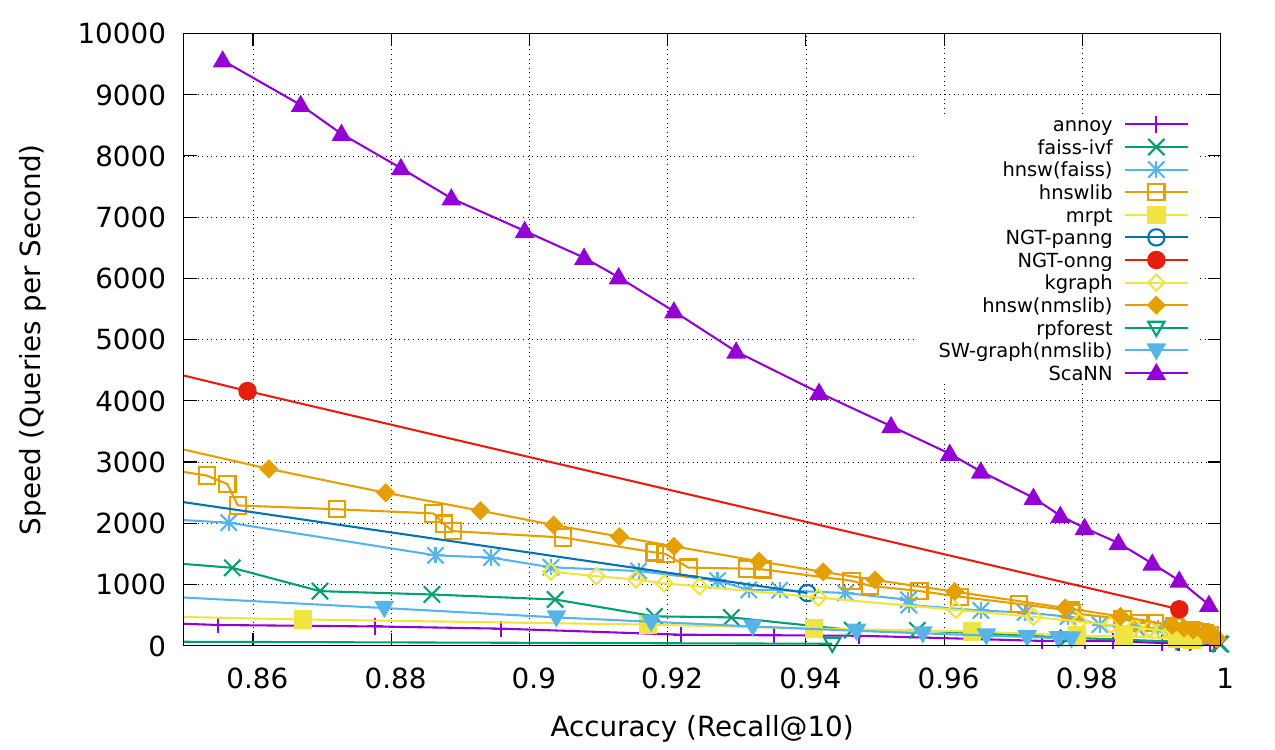

### Open the output file to write all the lines to the file

In [ ]:
#outFile = open(config['output_file'], 'w')
#for n_user in neighbors(user,k_value):
#    user_id = list(user_likes.keys())[n_user]
#    for item_id in user_likes[user_id]:
#        outFile.write(str(item_id) + ' ' + str(user_id) + '\n')
#outFile.close()